## Tutorial - 0: Continuous Forward Schrodinger

Welcome to our first tutorial on Physics-Informed Neural Networks (PINNs) using `PyTorch Lightning` and our new package, **`pinnstorch`**! This guide aims to introduce you to the integration of deep learning and scientific computing via PINNs, which embed physical laws into neural network training.

#### Overview:

- **Mesh Generation and Sampling:** Understanding how to create and use meshes for training PINNs, crucial for defining the domain of our problem.
- **Neural Network Model with PINNs:** How to build and structure a neural network for physical law integration.
- **Physical Laws in Neural Networks:** Detailing the implementation of differential equations within the network using `pde_fn` and `output_fn`.
- **Training and Validation:** Utilizing PyTorch Lightning’s Trainer to train our model, including defining the training data, initial conditions, and handling boundary conditions.
- **Results Visualization:** Saving and analyzing the outcomes of your PINN models.

#### Install Libraries

In [1]:
!pip install pinnstorch
!pip install lightning

#### Import Libraries

In [2]:
from typing import Dict

import torch
import numpy as np
import lightning.pytorch as pl

import pinnstorch
from pinnstorch.models.net.activations import SineActivation, GaussianActivation, WireActivation, HoscActivation, SincActivation


### Define Mesh

Physics-Informed Neural Networks (PINNs) require a discretized domain (mesh) over which the physical equations are solved. In `pinnstorch`, there are primarily two approaches to define this mesh:


- **Defining Time and Spatial Domains Separately:** Here, we use `pinnstorch.data.TimeDomain` and `pinnstorch.data.Interval` for creating 1-D spatial domains. These domains are then used to define a `pinnstorch.data.Mesh`.

- **Defining Point Clouds:** This method involves directly utilizing spatio-temporal data (e.g., from experiments or other simulations) to create a mesh using `pinnstorch.data.PointCloud`.

Both approaches should ideally yield the same results.

#### Option 1: Defining Mesh with Separate Time and Spatial Domains

We start by defining a function to read and preprocess the solution data from a file. The output should be a dictionary.

In [3]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in Mesh class.
    """

    data = pinnstorch.utils.load_data(root_path, "NLS.mat")
    exact = data["uu"] # complex number shape N x T
    exact_u = np.real(exact) # N x T # real part
    exact_v = np.imag(exact) # N x T # imaginary part
    exact_h = np.sqrt(exact_u**2 + exact_v**2) # N x T # absolute value ----> ||X|| = sqrt(x^2 + y^2)
    return {"u": exact_u, "v": exact_v, "h": exact_h} # return dict of solutions {u:real, v:imag, h:absolute value}

Now, define the time and spatial domains for mesh generation. The choice of these parameters depends on the specific problem being solved and should be set accordingly.

In [4]:
time_domain = pinnstorch.data.TimeDomain(t_interval=[0, 1.57079633], t_points = 201)
spatial_domain = pinnstorch.data.Interval(x_interval= [-5, 4.9609375], shape = [256, 1])

In [5]:
help(time_domain)
time_domain

Help on TimeDomain in module pinnstorch.data.domains.time object:

class TimeDomain(builtins.object)
 |  TimeDomain(t_interval, t_points: int)
 |  
 |  Initialize a time domain.
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, idx)
 |      Get a specific time point from the time domain using indexing.
 |      
 |      :param idx: The index of the desired time point.
 |      :return: The time value at the specified index.
 |  
 |  __init__(self, t_interval, t_points: int)
 |      Initialize a TimeDomain object to represent a time domain.
 |      
 |      :param t_interval: A tuple or list representing the time interval [start_time, end_time].
 |      :param t_points: The number of time points to discretize the interval.
 |  
 |  __len__(self)
 |      Get the length of the time domain.
 |      
 |      :return: The number of time points in the time domain.
 |  
 |  generate_mesh(self, spatial_points)
 |      Generate a mesh of time based on number of spatial points.
 |      
 | 

The mesh is then defined using the time and spatial domains along with the read_data_fn function. 

In [6]:
mesh = pinnstorch.data.Mesh(root_dir='../data',
                            read_data_fn=read_data_fn,
                            spatial_domain = spatial_domain,
                            time_domain = time_domain)

#### Option 2: Using Point Clouds

For scenarios where the spatial and temporal data along with solutions are directly available (e.g., from experimental measurements), we can create a mesh using `pinnstorch.data.PointCloud`.

**Note:** It's crucial to format the spatial and temporal domain dimensions correctly. Specifically:

- **Spatial Domain:** Each axis should be structured in the shape of $(N \times 1)$, where $N$ represents the number of spatial points.
- **Time Domain:** This should be formatted as $(T \times 1)$, where $T$ indicates the number of time steps.
- **Solution Data:** Each solution variable (e.g., temperature, velocity) should be in the shape of $(N \times T)$, aligning with the spatial and temporal points.

In [7]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in PointCloud class.
    """

    data = pinnstorch.utils.load_data(root_path, "NLS.mat")

    x = data["x"].T  # N x 1
    t = data["tt"].T  # T x 1
    
    exact = data["uu"]
    exact_u = np.real(exact) # N x T
    exact_v = np.imag(exact) # N x T
    exact_h = np.sqrt(exact_u**2 + exact_v**2) # N x T

    print(f" x has {x.shape} shape with min: {x.min()}, max: {x.max()}")
    print(f" t has {t.shape} shape with min: {t.min()}, max: {t.max()}")
    print(f"  exact_u {exact_u.shape} shape with min: {exact_u.min()}, max: {exact_u.max()}")
    print(f" exact_v {exact_v.shape} shape with min: {exact_v.min()}, max: {exact_v.max()}")
    print(f" exact_h  {exact_h.shape} shape with min: {exact_h.min()}, max: {exact_h.max()}")


    
    return pinnstorch.data.PointCloudData(
            spatial=[x], time=[t], solution={"u": exact_u, "v": exact_v, "h": exact_h}
    )

Now, mesh can be initalize with using the function and the directory to the folder of data.

In [8]:
mesh = pinnstorch.data.PointCloud(root_dir='./data',
                                  read_data_fn=read_data_fn)

 x has (256, 1) shape with min: -5.0, max: 4.9609375
 t has (201, 1) shape with min: 0.0, max: 1.5707963267948966
  exact_u (256, 201) shape with min: -3.932425448799453, max: 2.1998422786360754
 exact_v (256, 201) shape with min: -3.4523031901896957, max: 2.754265786698505
 exact_h  (256, 201) shape with min: 0.015981892796576278, max: 3.9987582390710266


### Define Train datasets

For solving Schrodinger PDE, we have:
- Initial condition
- Periodic boundary condition
- Collection points for the PDE.

#### Initial Condition

Let's start with initial condition of the Schrodinger.
$$ u(0, x) = 2 \text{sech}(x) $$
$$ v(0, x) = 0 $$

For defining initial condition, again we have two options.

- **Sample from the data.**
- **Defining a function for calculating initial condition.**

##### Set number of samples

In [9]:
N0 = 50

##### Option 1: Sample from the data

In [10]:
in_c = pinnstorch.data.InitialCondition(mesh = mesh,
                                        num_sample = N0,
                                        solution = ['u', 'v'])

##### Option 2: Defining a function for calculating initial condition

The input of `initial_fun` should be the same as spatial domain of the problem.

In [11]:
def initial_fun(x):
    return {'u': 2*1/np.cosh(x), 'v': np.zeros_like(x)}

In [12]:
in_c = pinnstorch.data.InitialCondition(mesh = mesh,
                                        num_sample = N0,
                                        initial_fun = initial_fun,
                                        solution = ['u', 'v'])

The `solution` attribute in `pinnstorch.data.InitialCondition` specifies the solutions (`u` and `v` in our case) to be sampled for initial conditions.

#### Periodic Boundary Condition

The `pinnstorch.data.PeriodicBoundaryCondition` is used to sample periodic points from the upper and lower bounds of the spatial domain (mesh). The `derivative_order` parameter specifies the order of the derivative to be matched at these boundaries. In our case, for the Schrödinger equation, both the function and its first spatial derivative should match at the boundaries, hence `derivative_order = 1`.


$$ u(t,-5) = u(t, 5), $$
$$ v(t,-5) = v(t, 5), $$ 
$$ u_x(t,-5) = u_x(t, 5),$$
$$ v_x(t,-5) = v_x(t, 5) $$

In [13]:
N_b = 50
pe_b = pinnstorch.data.PeriodicBoundaryCondition(mesh = mesh,
                                                 num_sample = 50,
                                                 derivative_order = 1,
                                                 solution = ['u', 'v'])

#### Mesh Sampler for collection points and solutions

In our problem, the partial differential equations (PDEs) governing the dynamics are given by:

$$ f_u := u_t + 0.5v_{xx} + v(u^2 +v^2),$$
$$ f_v := v_t + 0.5u_{xx} + u(u^2 +v^2) $$

To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnstorch.data.MeshSampler` for this purpose, specifying the following:

- **Number of Sample Points (N_f):** We choose to sample 20,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.
- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.
- **Collection Points:** We define `['f_u', 'f_v']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.

Here's the code to implement this sampler:

In [14]:
N_f = 20000
me_s = pinnstorch.data.MeshSampler(mesh = mesh,
                                   num_sample = N_f,
                                   collection_points = ['f_v', 'f_u'])

### Define Validation dataset

For validation, we sample all points from the mesh to evaluate our model comprehensively. Model will be validated for solutions of `u`, `v`, and `h`.

**Note:** If `num_sample` is not specified, the sampler will use the entire mesh for data sampling.

In [15]:
val_s = pinnstorch.data.MeshSampler(mesh = mesh,
                                    solution = ['u', 'v', 'h'])

In [16]:
# SineActivation, GaussianActivation, WireActivation, HoscActivation, SincActivation

net = pinnstorch.models.FCN(layers = [2, 100, 100, 100, 100, 2],
                            output_names = ['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="SINE",                  # use registry
                            activation_kwargs={'omega':5},    # extra params
                            initializer="SIREN",                # use registry
                            initializer_kwargs={'in_features': 2, 'omega':5}, # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                             )

### Define `pde_fn` and `output_fn` functions

Now, we define `pde_fn` and `output_fn`.
- **`output_fn`:** is applied to the network's output, adding any necessary post-processing computations. For example, in our case, `h(x,t) = u(x,t)**2 + v(x,t)**2`, thus, we define this equation in `output_fn`.
- **`pde_fn`:** formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points. 

#### `output_fn` function

**Note:** `output_fn` should always have these inputs:
- **Outputs:** It is output of the network. In our case, this dictionary should have two output: `u` and `v`.
- **Spatial domains:** These are the spatial domain variables. In our case, because our problem has 1-D spatial domain, the input just have `x`. For example, if we had 2-D space, we need another input for that dimention. For example, the inputs from `(outputs, x, t)` will be changed to `(outputs, x, y, t)`.
- **Time domin:** The last input of `output_fn` function always should be time.

In [17]:
def output_fn(outputs: Dict[str, torch.Tensor],
              x: torch.Tensor,
              t: torch.Tensor):
    """Define `output_fn` function that will be applied to outputs of net."""

    outputs["h"] = torch.sqrt(outputs["u"] ** 2 + outputs["v"] ** 2)

    return outputs

#### `pde_fn` function

The inputs are similar to `output_fn`. Only if we have extra variables for training (i.g. in inverse problems), we should add input at the end of inputs. For example, `(outputs, x, t)` will be `(outputs, x, t, extra_variable)`. `extra_variable` is always a dictionary.

In [18]:
def pde_fn(outputs: Dict[str, torch.Tensor],
           x: torch.Tensor,
           t: torch.Tensor):   
    """Define the partial differential equations (PDEs)."""
    u_x, u_t = pinnstorch.utils.gradient(outputs["u"], [x, t])
    v_x, v_t = pinnstorch.utils.gradient(outputs["v"], [x, t])

    u_xx = pinnstorch.utils.gradient(u_x, x)[0]
    v_xx = pinnstorch.utils.gradient(v_x, x)[0]

    outputs["f_u"] = u_t + 0.5 * v_xx + (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["v"]
    outputs["f_v"] = v_t - 0.5 * u_xx - (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["u"]

    return outputs

### Define PINNDataModule and PINNModule

To integrate with Lightning, we utilize two specialized modules:

- `PINNDataModule` (inherited from `LightningDataModule`) manages data.
- `PINNModule` (derived from `LightningModule`) handles the model, compilation, and various enhancements like AMP.

#### Define `PINNDataModule`
Here, we define collection points, initial condition, and preiodic boundary condition as training datasets, and also, we set validation set. `PINNDataModule` is used for defining training, validation, prediction, and test datasets.

In [19]:
train_datasets = [me_s, in_c, pe_b]
val_dataset = val_s
datamodule = pinnstorch.data.PINNDataModule(train_datasets = [me_s, in_c, pe_b],
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

#### Define `PINNModule`

`PINNModule` handle several things. Here, we will explore the inputs of this class:
- **net:**  The neural network.
- **pde_fn:** The function representing the PDE to solve.
- **optimizer:**  (Optional) The optimizer for training. The default is Adam
- **loss_fn:** (Optional) The loss function to use, either "sse" or "mse". The default is "sse".
- **scheduler:** (Optional) Learning rate scheduler. The default is None.
- **scaler:** (Optional) Gradient scaler for AMP. The default is `torch.cuda.amp.GradScaler`.
- **extra_variables:** (Optional) Extra variables in inverse problems. The default is None.
- **output_fn:** (Optional) function to process the model's output. The default is None.
- **runge_kutta:** (Optional) Runge-Kutta method for solving PDEs in discrete mode. The default is None.
- **cudagraph_compile:** Flag to enable CUDA Graph compilation. It works only with a single GPU. The default is True.
- **jit_compile:** (Optional) Flag to enable JIT compilation. The default is True.
- **amp:** (Optional) Flag to enable Automatic Mixed Precision (AMP). The default is False.
- **inline:** (Optional) Flag to enable inline mode in JIT compilation. The default is False.

In this example, we initalize `PINNModule` with defined variables. We set Adam optimizer and try to compile the model with CUDA Graph. The loss function here is Mean Square Error (MSE).

In [20]:
model = pinnstorch.models.PINNModule(net = net,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

### Setting Up the Trainer

For training our model, we configure a trainer in PyTorch Lightning. Currently, our setup uses a single GPU, as models compiled with CUDA Graph don't support multiple GPUs yet. For a comprehensive understanding of the trainer's options and functionalities, refer to the [official documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html). For example, arguments that you can set are:
- **accelerator:**  Supports passing different accelerator types such as `cpu`, `gpu`, `tpu`, `ipu`, `hpu`, `mps`, and `auto`.
- **devices:** The devices to use. Can be set to a positive number (int or str), a sequence of device indices (list or str), the value -1 to indicate all available devices should be used, or "auto" for automatic selection based on the chosen accelerator. Default: "auto".
- **max_epochs:** Stop training once this number of epochs is reached.
- **max_steps:** Stop training after this number of steps.
- ...

In our example, we configure the trainer for CPU use, specifying one device:

In [21]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs = 1000)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


### Training


In [22]:
%%time
trainer.fit(model=model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:377: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:
C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten

Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=40, train/loss_step=1.350]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:
C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten


Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s, v_num=40, train/loss_step=1.090, val/loss=1.340, val/error_u=0.937, val/error_v=1.040, val/error_h=0.850, val/loss_best=1.340, train/loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:03<00:00,  0.28it/s, v_num=40, train/loss_step=0.581, val/loss=1.130, val/error_u=0.835, val/error_v=1.030, val/error_h=0.758, val/loss_best=1.130, train/loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 34.47it/s, v_num=40, train/loss_step=0.465, val/loss=1.060, val/error_u=0.814, val/error_v=1.020, val/error_h=0.720, val/loss_best=1.060, train/loss_epoch=0.581]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s, v_num=40, train/loss_step=0.0195, val/loss=1.060, val/error_u=1.090, val/error_v=1.170, val/error_h=0.272, val/loss_best=0.842, train/loss_epoch=0.0195]
CPU times: total: 1min 24s
Wall time: 1min 25s


### Validation

In [23]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.27209174633026123    │
│        val/error_u        │     1.087910532951355     │
│        val/error_v        │     1.168275237083435     │
│         val/loss          │    1.0608665943145752     │
│       val/loss_best       │    0.8415444493293762     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 1.0608665943145752,
  'val/error_u': 1.087910532951355,
  'val/error_v': 1.168275237083435,
  'val/error_h': 0.27209174633026123,
  'val/loss_best': 0.8415444493293762}]

### Plotting

For plotting, we need predict the results, and then, we should concatenate the results.

In [24]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


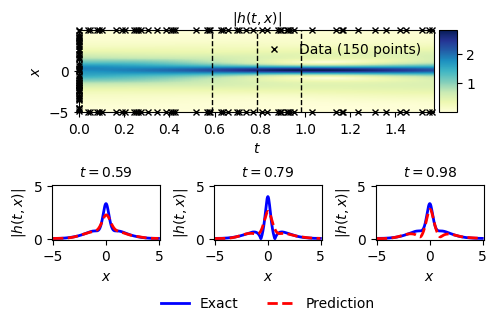

In [25]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out')